## Count terms appearing in tweets

This notebook produces the graph with frequency counts of Dutch tweets related to the COVID-19 crisis. It relies on the texts of the tweets in the directory data/text and will count all the tweets in that directory. The notebook should be run every month after the tweets in the directory have been updated. Tweet counts are cached but generating the counts for one month will still take more than seven hours.

In [1]:
import gzip
import json
import os
import pandas as pd
import re

DATADIR = "../data/text/"

In [2]:
TEXT = "text"
FULLTEXT = "full_text"
EXTENDEDTWEET = "extended_tweet"
RETWEETEDSTATUS = "retweeted_status"

def getTweetText(jsonData):
    text = ""
    if TEXT in jsonData: 
        text = jsonData[TEXT]
    if EXTENDEDTWEET in jsonData and \
       FULLTEXT in jsonData[EXTENDEDTWEET]:
        text = jsonData[EXTENDEDTWEET][FULLTEXT]
    if RETWEETEDSTATUS in jsonData and \
       EXTENDEDTWEET in jsonData[RETWEETEDSTATUS] and \
       FULLTEXT in jsonData[RETWEETEDSTATUS][EXTENDEDTWEET]:
        text = jsonData[RETWEETEDSTATUS][EXTENDEDTWEET][FULLTEXT]
    return(text)

In [3]:
from datetime import datetime, timedelta

DATEFORMAT = "%a %b %d %H:%M:%S %z %Y"
SUMMERTIMEDATE = datetime.strptime("Sun Mar 29 02:00:00 +0000 2020",DATEFORMAT)
WINTERTIMEDATE = datetime.strptime("Sun Oct 25 03:00:00 +0000 2020",DATEFORMAT)

def getTweetDate(jsonData):
    dateString = jsonData["created_at"]
    dateData = datetime.strptime(dateString,DATEFORMAT)+timedelta(hours=1)
    if dateData >= SUMMERTIMEDATE:
        if dateData >= WINTERTIMEDATE: sys.exit("cannot happen")
        dateData += timedelta(hours=1)
    return(int(dateData.strftime("%Y%m%d")))

In [6]:
CSVSUFFIX = ".csv"
DUTCH = "nl"
IDSTR = "id_str"
TOPIC = "topic"
DISTANCE = "distance"
TOPICQUERY = "corona|covid|huisarts|mondkapje|rivm|blijfthuis|flattenthecurve|houvol"
DISTANCEQUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"

fileNames = sorted(os.listdir(DATADIR))

def saveCounts(counts,outFileName):
    pd.DataFrame.from_dict(counts,orient="index").to_csv(outFileName,header=False)

def readCounts(inFileName):
    countsDf = pd.read_csv(inFileName,header=None,index_col=0)
    return(countsDf.to_dict()[1])

def combineDicts(a,b):
    return(dict(list(a.items())+list(b.items())))

def search(query,countsIn):
    countsOut = {}
    countsInKeys = [ str(x) for x in countsIn ]
    seen = {}
    for inFileName in fileNames:
        date = inFileName[0:8]
        if re.search(r"2*z",inFileName) and not date in countsInKeys:
            inFile = gzip.open(DATADIR+inFileName,mode="rt")
            for line in inFile:
                jsonData = json.loads(line)
                tweetText = getTweetText(jsonData)
                tweetDate = getTweetDate(jsonData)
                tweetLang = jsonData["lang"]
                if tweetLang == DUTCH and re.search(query,tweetText,flags=re.IGNORECASE):
                    if tweetDate in countsOut: countsOut[tweetDate] += 1
                    else: countsOut[tweetDate] = 1
            inFile.close()
            if not date in seen:
                print(date)
                seen[date] = True
    countsOut = combineDicts(countsIn,countsOut)
    countsOut = {k:v for k, v in sorted(countsOut.items(), key=lambda item: item[0])}
    return(countsOut)

def searchText(query,countsIn):
    countsOut = {}
    countsInKeys = [ str(x) for x in countsIn ]
    query = query.lower()
    if query == TOPIC: query = TOPICQUERY
    elif query == DISTANCE: query = DISTANCEQUERY
    for inFileName in fileNames:
        date = inFileName[0:8]
        if re.search(r"2*z",inFileName) and not date in countsInKeys:
            if not date in countsOut: 
                countsOut[date] = 0
                print(date,query)
            df = pd.read_csv(DATADIR+inFileName,index_col=IDSTR)
            for i in range(0,len(df)):
                if re.search(query,df.iloc[i][TEXT].lower()):
                    countsOut[date] += 1
    countsOut = combineDicts(countsIn,countsOut)
    countsOut = {str(k):v for k, v in sorted(countsOut.items(), key=lambda item: str(item[0]))}
    return(countsOut)

In [5]:
rivm = readCounts("rivm.csv")
corona = readCounts("corona.csv")
covid = readCounts("covid.csv")
mondkapje = readCounts("mondkapje.csv")
topic = readCounts("topic.csv")
distance = readCounts(DISTANCE+CSVSUFFIX)

In [ ]:
def deleteLastElement(myDict):
    del(myDict[list(myDict.keys())[-1]])

if False:
    deleteLastElement(rivm)
    rivm = searchText("rivm",rivm)
    saveCounts(rivm,"rivm.csv")
    deleteLastElement(corona)
    corona = searchText("corona",corona)
    saveCounts(corona,"corona.csv")
    deleteLastElement(covid)
    covid = searchText("covid",covid)
    saveCounts(covid,"covid.csv")
    deleteLastElement(mondkapje)
    mondkapje = searchText("mondkapje",mondkapje)
    saveCounts(mondkapje,"mondkapje.csv")
    deleteLastElement(topic)
    topic = searchText("topic",topic)
    saveCounts(topic,"topic.csv")   

In [11]:
import math
from warnings import warn

WEEKLENGTH = 7

def summarize(myDict,index,count):
    counter = 0
    mySum = 0
    myKeys = list(myDict.keys())
    for i in range(0,count):
        if index-i >= 0 and not math.isnan(myDict[myKeys[index-i]]):
            counter += 1
            mySum += myDict[myKeys[index-i]]
            if myKeys[index-i] > myKeys[index]:
                warn("keys are not sorted!")
    if counter == 0: return(math.nan)
    else: return(mySum/counter)

rivm7 = {list(rivm.keys())[i]:summarize(rivm,i,WEEKLENGTH) for i in range(0,len(rivm))}
corona7 = {list(corona.keys())[i]:summarize(corona,i,WEEKLENGTH) for i in range(0,len(corona))}
covid7 = {list(covid.keys())[i]:summarize(covid,i,WEEKLENGTH) for i in range(0,len(covid))}
mondkapje7 = {list(mondkapje.keys())[i]:summarize(mondkapje,i,WEEKLENGTH) for i in range(0,len(mondkapje))}
topic7 = {list(topic.keys())[i]:summarize(topic,i,WEEKLENGTH) for i in range(0,len(topic))}
distance7 = {list(distance.keys())[i]:summarize(distance,i,WEEKLENGTH) for i in range(0,len(distance))}

### Plot absolute values

In [12]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

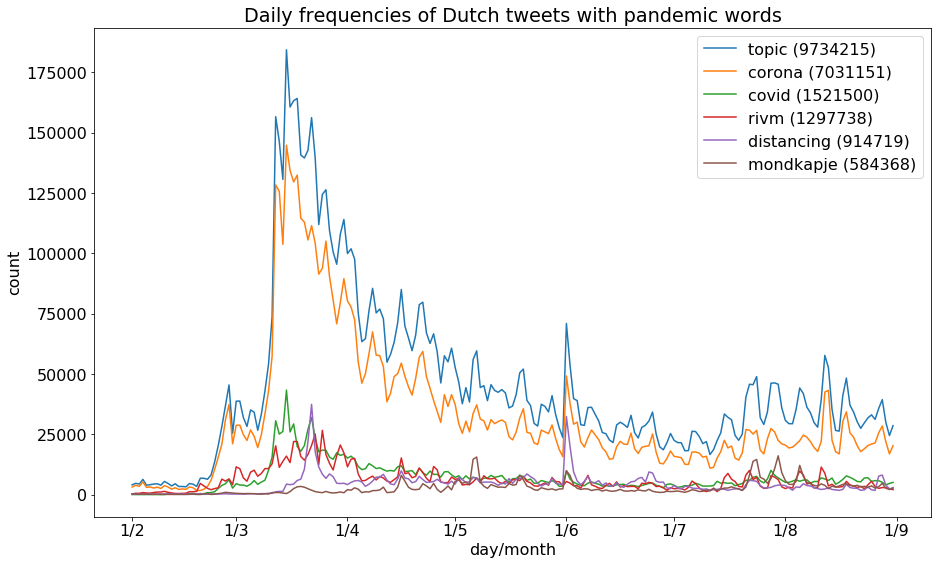

In [16]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
#%matplotlib inline

DATEFORMATPLOT = "%Y%m%d"
PLOTFILEOUT = "tweet-frequencies.png"

def getWeekendDates(dateStrings):
    weekendDates = []
    for ds in dateStrings:
        d = datetime.strptime(str(ds),DATEFORMATPLOT)
        if d == 0 or d == 6: weekendDates.append(d)
            
def stringArrayToDates(stringList,dateFormat=DATEFORMATPLOT):
    return([datetime.strptime(str(date),dateFormat) for date in stringList])

def makeLabel(name,myDict):
    return(name+" ("+str(sum(myDict.values()))+")")

weakendDates = getWeekendDates(rivm.keys())
font = {"size":16}
matplotlib.rc("font",**font)
plt.figure(figsize=(15,9))
ax1 = plt.subplot(111)
ax1.plot_date(stringArrayToDates(topic.keys()),list(topic.values()),xdate=True,fmt="-",label=makeLabel("topic",topic))
ax1.plot_date(stringArrayToDates(corona.keys()),list(corona.values()),xdate=True,fmt="-",label=makeLabel("corona",corona))
ax1.plot_date(stringArrayToDates(covid.keys()),list(covid.values()),xdate=True,fmt="-",label=makeLabel("covid",covid))
ax1.plot_date(stringArrayToDates(rivm.keys()),list(rivm.values()),xdate=True,fmt="-",label=makeLabel("rivm",rivm))
ax1.plot_date(stringArrayToDates(distance.keys()),list(distance.values()),xdate=True,fmt="-",label=makeLabel("distancing",distance))
ax1.plot_date(stringArrayToDates(mondkapje.keys()),list(mondkapje.values()),xdate=True,fmt="-",label=makeLabel("mondkapje",mondkapje))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
dummy = ax1.legend()
plt.title("Daily frequencies of Dutch tweets with pandemic words")
plt.xlabel("day/month")
plt.ylabel("count")
plt.savefig(PLOTFILEOUT)
plt.show()

In [ ]:
monthCounts = {}
for date in topic:
    month = str(date)[0:6]
    if not month in monthCounts: monthCounts[month] = 0
    monthCounts[month] += topic[date]
monthCounts

### Plot normalized values

In [ ]:
import pandas as pd

def normalize(dateCounts,countsIn):
    countsOut = {}
    for key in countsIn:
        if int(key) in dateCounts.index: 
            countsOut[key] = countsIn[key]/dateCounts.loc[int(key)]["count"]
    return(countsOut)

dateCounts = pd.read_csv(DATADIR+"../date-counts.csv",index_col=["date"])

In [ ]:
rivmNorm = normalize(dateCounts,rivm)
coronaNorm = normalize(dateCounts,corona)
covidNorm = normalize(dateCounts,covid)
mondkapjeNorm = normalize(dateCounts,mondkapje)
topicNorm = normalize(dateCounts,topic)

rivmNorm7 = {list(rivmNorm.keys())[i]:summarize(rivmNorm,i,WEEKLENGTH) for i in range(0,len(rivmNorm))}
coronaNorm7 = {list(coronaNorm.keys())[i]:summarize(coronaNorm,i,WEEKLENGTH) for i in range(0,len(coronaNorm))}
covidNorm7 = {list(covidNorm.keys())[i]:summarize(covidNorm,i,WEEKLENGTH) for i in range(0,len(covidNorm))}
mondkapjeNorm7 = {list(mondkapjeNorm.keys())[i]:summarize(mondkapjeNorm,i,WEEKLENGTH) for i in range(0,len(mondkapjeNorm))}
topicNorm7 = {list(topicNorm.keys())[i]:summarize(topicNorm,i,WEEKLENGTH) for i in range(0,len(topicNorm))}

In [ ]:
plt.figure(figsize=(10,8))
ax2 = plt.subplot(111)
ax2.plot_date(stringArrayToDates(topicNorm7.keys()),list(topicNorm7.values()),xdate=True,fmt="-",label=makeLabel("topic",topic))
ax2.plot_date(stringArrayToDates(coronaNorm7.keys()),list(coronaNorm7.values()),xdate=True,fmt="-",label=makeLabel("corona",corona))
ax2.plot_date(stringArrayToDates(covidNorm7.keys()),list(covidNorm7.values()),xdate=True,fmt="-",label=makeLabel("covid",covid))
ax2.plot_date(stringArrayToDates(mondkapjeNorm7.keys()),list(mondkapjeNorm7.values()),xdate=True,fmt="-",label=makeLabel("mondkapje",mondkapje))
ax2.plot_date(stringArrayToDates(rivmNorm7.keys()),list(rivmNorm7.values()),xdate=True,fmt="-",label=makeLabel("rivm",rivm))
plt.title("Daily fractions of Dutch tweets with pandemic words (moving average over 7 days)")
plt.xticks([datetime.strptime(d,DATEFORMATPLOT) for d in "20200301 20200401 20200501 20200601 20200701 20200801".split()])
dummy = ax2.legend()

## Content analysis

In [ ]:
import gzip
import json
import os
import numpy as np
import pandas as pd
import re

DATADIR = "../data/all/"
ID = "id_str"
LANG = "lang"
USER = "user"
SCREENNAME = "screen_name"
RIVM = "rivm"
DUTCH = "nl"
TARGETDATES = ["20200412","20200413","20200414","20200415","20200416","20200417","20200418"]
QUERY = "mondkapje"

def removeNewlines(text):
    return(re.sub(r"\n"," ",text))

fileNames = os.listdir(DATADIR)
texts = {}
dates = {}
for inFileName in fileNames:
    inFileDate = inFileName[0:8]
    if inFileDate in TARGETDATES:
        inFile = gzip.open(DATADIR+inFileName,mode="rt")
        for line in inFile:
            jsonData = json.loads(line)
            tweetText = removeNewlines(getTweetText(jsonData))
            tweetLang = jsonData[LANG]
            tweetId = jsonData[ID]
            tweetUser = jsonData[USER][SCREENNAME]
            if tweetLang == DUTCH and \
               re.search(QUERY,tweetText,flags=re.IGNORECASE) and \
               re.search(RIVM,tweetText,flags=re.IGNORECASE):
                texts[tweetId] = {"user":tweetUser,"text":tweetText}
                dates[tweetId] = int(inFileDate)
        inFile.close()
len(texts)

In [ ]:
pd.DataFrame.from_dict(texts,orient="index").to_csv("mondkapje-tweets.csv",header=False)

In [ ]:
ANNOTATIONFILE = "mondkapje-tweets.csv.human-labels.txt"

inFile = open(DATADIR+"../"+ANNOTATIONFILE,"r")
annotations = {}
minutes = {}
for line in inFile:
    (userName,date,tweetId,nbr,label) = line.strip().split()
    annotations[tweetId] = label
    minutes[date[0:12]] = True
inFile.close()

print("annotation time: {0:d} minutes ({1:0.1f} tweets per minute)".\
      format(len(minutes),round(len(annotations)/len(minutes),1)))

In [ ]:
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
NEGATIVE = "NEGATIVE"
POSITIVE = "POSITIVE"

labelsPerDate = {}
totals = {}
for tweetId in dates:
    if tweetId in annotations and annotations[tweetId] != IRRELEVANT:
        date = int(dates[tweetId])
        label = annotations[tweetId]
        if not date in labelsPerDate: labelsPerDate[date] = {}
        labelsPerDate[date][label] = labelsPerDate[date][label]+1 if label in labelsPerDate[date] else 1
        totals[label] = totals[label]+1 if label in totals else 1
labelsPerDate

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

labels = {"NEGATIVE":"rejects","POSITIVE":"supports","NEUTRAL":"neutral"}
percentages = {key:round(100*totals[key]/sum(totals.values())) for key in totals}
font = {"size":16}
matplotlib.rc("font",**font)

for date in labelsPerDate:
    for label in [NEGATIVE,NEUTRAL,POSITIVE]:
        if not label in labelsPerDate[date]:
            labelsPerDate[date][label] = 0

negative = [labelsPerDate[date][NEGATIVE] for date in labelsPerDate.keys()]
neutral = [labelsPerDate[date][NEUTRAL] for date in labelsPerDate.keys()]
positive = [labelsPerDate[date][POSITIVE] for date in labelsPerDate.keys()]
negplusneu = [negative[i]+neutral[i] for i in range(0,len(neutral))]
plt.figure(figsize=(12,8))
plt.bar(list(labelsPerDate.keys()),positive,label=labels[POSITIVE]+" ("+str(percentages[POSITIVE])+"%)",bottom=negplusneu)
plt.bar(list(labelsPerDate.keys()),neutral,label=labels[NEUTRAL]+" ("+str(percentages[NEUTRAL])+"%)",bottom=negative)
plt.bar(list(labelsPerDate.keys()),negative,label=labels[NEGATIVE]+" ("+str(percentages[NEGATIVE])+"%)",color="r")
plt.title("Twitter stance on RIVM advising against facemask use by general public")
plt.xticks(list(labelsPerDate.keys()),["Fri 17/4","Wed 15/4","Sun 12/4","Thu 16/4","Mon 13/4","Tue 14/4"])
plt.legend()
plt.show()

## twiqs.nl tweets per month (alltime)

In [ ]:
from datetime import datetime
import pandas as pd
import re
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
DATAFILE = "../data/months.txt"
DATEFORMAT = "%Y%m"

In [ ]:
df = pd.read_csv(DATAFILE,sep=" ",header=None,index_col=0)

In [ ]:
font = {"size":14}
matplotlib.rc("font",**font)
plt.figure(figsize=(12,8))
ax2 = plt.subplot(111)
ax2.set_ylim([0,90000000])
ax2.plot_date([datetime.strptime(str(month),DATEFORMAT) for month in df.index if month > 201100],\
               [df.loc[month][1] for month in df.index if month > 201100],fmt="-")
plt.title("number of Dutch tweets collected by twiqs.nl per month")
plt.show()